#**Match Result Binary Classification with PyCaret** - Skander Chouchene

Binary classification is a supervised machine learning technique where the goal is to classify instances into one of two classes.

**Install Pycaret**

In [2]:
# install slim version (default): if you get an error message, run it again
!pip install pycaret==2.3.6

In [3]:
#Run the below code in your notebook to check the installed version
from pycaret.utils import version
version()

'2.3.6'

**Import Libraries**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (7,5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
print("Pandas version: ", pd.__version__)
print("Seaborn version: ", sns.__version__)

Pandas version:  1.3.5
Seaborn version:  0.11.2


**Dataset**

![EPL](https://www.sport.fr/wp-content/uploads/2020/11/paris-sportif-premier-league.jpg)

We look at the football match results of matches within the English Premier League Result. It contains several features that are used by
football analysts, for the aim of predicting the target variable
result, which has 2 classes; ”l” for loss, and ”w” for win.

The dataset will be filtered beforehand to only show home
games and eliminate draw results, for simplification purposes.

The dataset contains 6 features:

• Expected Goals (xG): A statistical measure of the quality
of chances created and conceded [5].<br>
• Number of players in the final third for the team (deep).
This feature gives us an idea on the strategy of the team
(possession, forward pressure, counter-attack, etc.)<br>
• Total shots for the team (HS.x)<br>
• Shots on target for the team (HST.x)<br>
• Total corners for the team (HC.x)<br>
• Bet365’s odds for the team’s win (B365H.x). The higher
the odd the lower the probability of the team’s win [6].<br>

https://www.kaggle.com/datasets/idoyo92/epl-stats-20192020

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#read cvs file into dataframe
df = pd.read_csv('/content/drive/MyDrive/epl2020.csv')
df = df[df['h_a'] == 'h']
df =df[df['result'] != 'd']

cols_to_keep = ['xG', 'deep', 'HS.x', 'HST.x', 'HC.x', 'B365H.x', 'result']
team_ids = df['teamId']
df = df[cols_to_keep].sample(n=200, random_state=25)
df.head(n=25)

xG  deep  HS.x  HST.x  HC.x  B365H.x result
159  0.650296     1    12      2     4     4.50      w
215  1.474400     6    12      3     1     5.00      l
520  1.781930     5    17      7     3     1.72      w
121  1.170220     1    12      2     6     9.00      l
366  1.475210     2    21      5    10     1.70      w
53   2.788210     9    25      5     6     1.50      w
330  0.805884     7    11      2     5     1.90      l
183  3.190040    18    25      9    13     1.08      w
335  0.718669     8    18      5    11     3.25      l
472  2.222820     7    14      3     7     1.40      w
483  2.722360     8    16      6     1     2.10      w
551  2.713510     6    14      5     3     8.00      w
343  0.138532     6     3      0     4     2.40      l
265  2.731850     6    19      6     9     1.28      l
461  0.674589     9     6      0     0     2.70      l
190  2.234940     8    13      5     5     4.50      l
278  2.243480     9    16      6     4     1.61      w
225  2.415800     5    14     12    11     2.25      w
336  0.281610     1     6      1     3     6.00      l
289  2.002320     9    14      5     6     1.72      w
114  0.513760     4     8      6     3     3.10      w
264  1.850900     5    15      4     5     2.25      l
479  0.878341     2     7      4     3     8.50      l
94   1.415420     3    13      6     7     2.90      w
210  2.583920     6    13      6     7     2.25      w

In [8]:
y = df['result']

lb = LabelEncoder()
lb.fit(['l', 'w'])
target = lb.transform(y)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 159 to 11
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   xG       200 non-null    float64
 1   deep     200 non-null    int64  
 2   HS.x     200 non-null    int64  
 3   HST.x    200 non-null    int64  
 4   HC.x     200 non-null    int64  
 5   B365H.x  200 non-null    float64
 6   result   200 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 12.5+ KB


In [10]:
print("Number of duplicated rows is: ", df.duplicated().sum())

Number of duplicated rows is:  0


In [11]:
print("Number of rows with NaNs is: ", df.isna().any(axis=1).sum())

Number of rows with NaNs is:  0


**Exploratory Data Analysis**

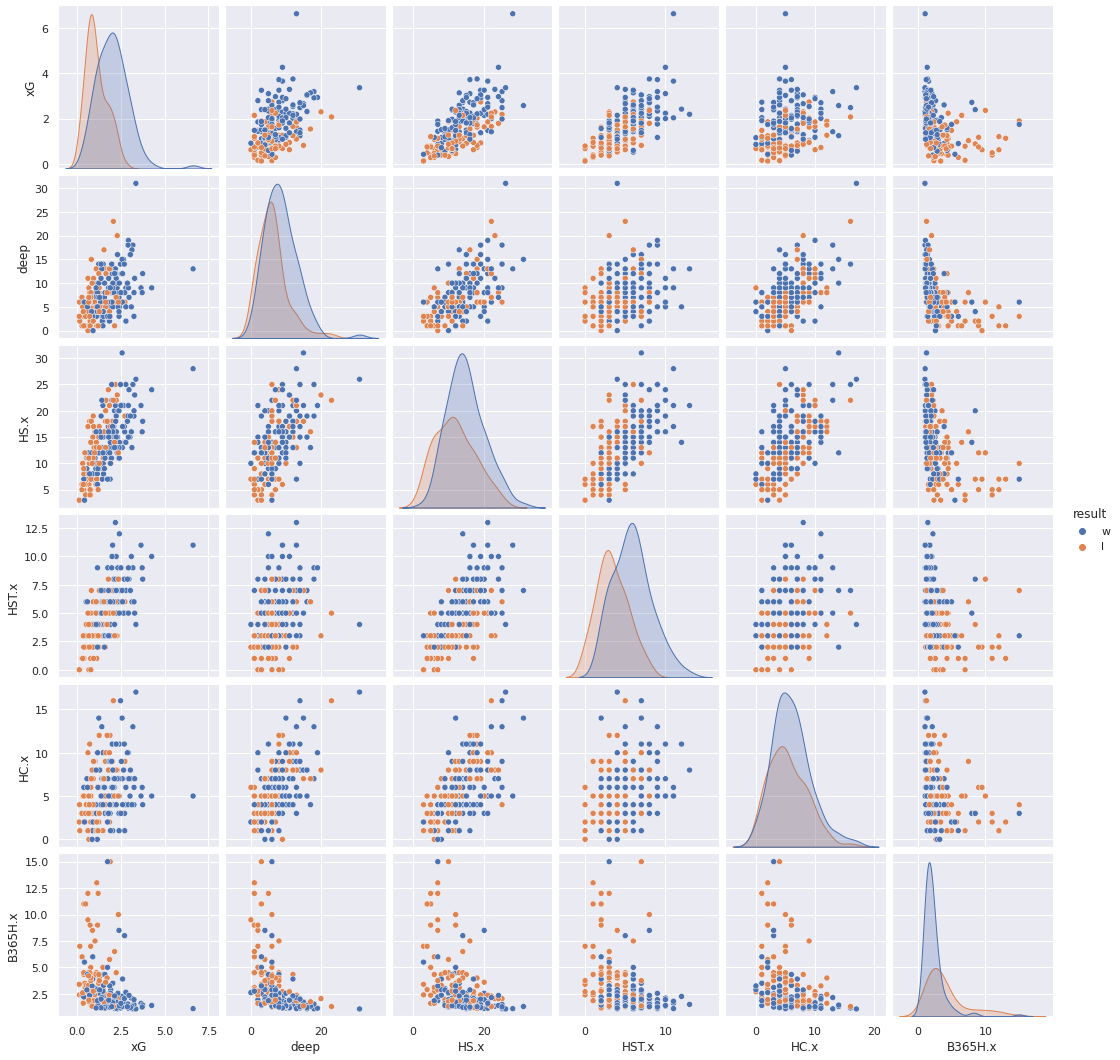

In [12]:
sns.pairplot(df, hue='result')
plt.show()

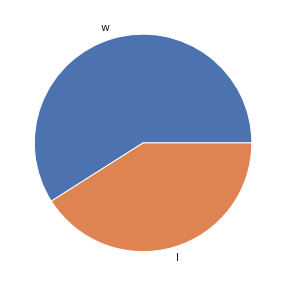

In [13]:
y =df['result']
y.value_counts().plot(kind='pie')
plt.ylabel('')
plt.show()

**Data Matrix**

In [14]:
X = df.drop(columns=['result'])
X.head(10)

xG  deep  HS.x  HST.x  HC.x  B365H.x
159  0.650296     1    12      2     4     4.50
215  1.474400     6    12      3     1     5.00
520  1.781930     5    17      7     3     1.72
121  1.170220     1    12      2     6     9.00
366  1.475210     2    21      5    10     1.70
53   2.788210     9    25      5     6     1.50
330  0.805884     7    11      2     5     1.90
183  3.190040    18    25      9    13     1.08
335  0.718669     8    18      5    11     3.25
472  2.222820     7    14      3     7     1.40

In [15]:
X.describe().transpose()

count       mean       std       min        25%       50%        75%  \
xG       200.0   1.635442  0.917784  0.120994   0.900718   1.51039   2.225425   
deep     200.0   7.545000  4.615680  0.000000   4.750000   7.00000  10.000000   
HS.x     200.0  13.635000  5.550298  3.000000  10.000000  13.00000  17.000000   
HST.x    200.0   4.855000  2.527035  0.000000   3.000000   5.00000   6.000000   
HC.x     200.0   5.780000  3.230134  0.000000   4.000000   5.00000   8.000000   
B365H.x  200.0   3.047000  2.549177  1.070000   1.530000   2.17500   3.325000   

              max  
xG        6.63049  
deep     31.00000  
HS.x     31.00000  
HST.x    13.00000  
HC.x     17.00000  
B365H.x  15.00000

**Standardize the Data**

In [16]:
Xs = StandardScaler().fit_transform(X)
Xcols = X.columns
X = pd.DataFrame(Xs)
X.columns = Xcols
X.head(10)

xG      deep      HS.x     HST.x      HC.x   B365H.x
0 -1.076090 -1.421551 -0.295318 -1.132618 -0.552443  0.571418
1 -0.175909 -0.335569 -0.295318 -0.735904 -1.483528  0.768052
2  0.160011 -0.552765  0.607795  0.850951 -0.862805 -0.521867
3 -0.508169 -1.421551 -0.295318 -1.132618  0.068280  2.341124
4 -0.175024 -1.204355  1.330286  0.057523  1.309726 -0.529732
5  1.259186  0.316021  2.052776  0.057523  0.068280 -0.608385
6 -0.906139 -0.118372 -0.475941 -1.132618 -0.242082 -0.451078
7  1.698111  2.270789  2.052776  1.644378  2.240810 -0.773558
8 -1.001405  0.098824  0.788418  0.057523  1.620087  0.079833
9  0.641602 -0.118372  0.065927 -0.735904  0.378641 -0.647712

In [17]:
X.describe().transpose()

count          mean       std       min       25%       50%  \
xG       200.0  6.661338e-17  1.002509 -1.654254 -0.802549 -0.136596   
deep     200.0  3.552714e-17  1.002509 -1.638748 -0.607064 -0.118372   
HS.x     200.0  3.774758e-17  1.002509 -1.920922 -0.656563 -0.114695   
HST.x    200.0 -1.731948e-16  1.002509 -1.926045 -0.735904  0.057523   
HC.x     200.0 -8.326673e-17  1.002509 -1.793890 -0.552443 -0.242082   
B365H.x  200.0  1.199041e-16  1.002509 -0.777491 -0.596587 -0.342930   

              75%       max  
xG       0.644447  5.456166  
deep     0.533217  5.094344  
HS.x     0.607795  3.136512  
HST.x    0.454237  3.231233  
HC.x     0.689003  3.482256  
B365H.x  0.109328  4.700732

**Observations and variables**

In [18]:
observations = list(df.index)
variables = list(df.columns)

**Box and Whisker Plots**

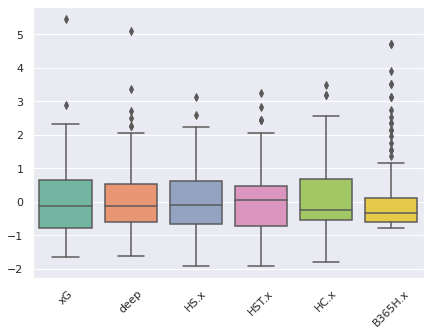

In [19]:
ax = plt.figure()
ax = sns.boxplot(data=X, orient="v", palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

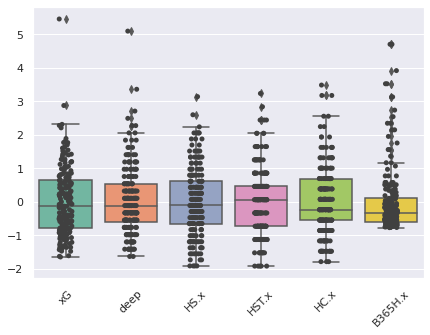

In [20]:
# Use swarmplot() or stripplot to show the datapoints on top of the boxes:
#plt. figure()
ax = plt.figure()    
ax = sns.boxplot(data=X, orient="v", palette="Set2")
ax = sns.stripplot(data=X, color=".25") 
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

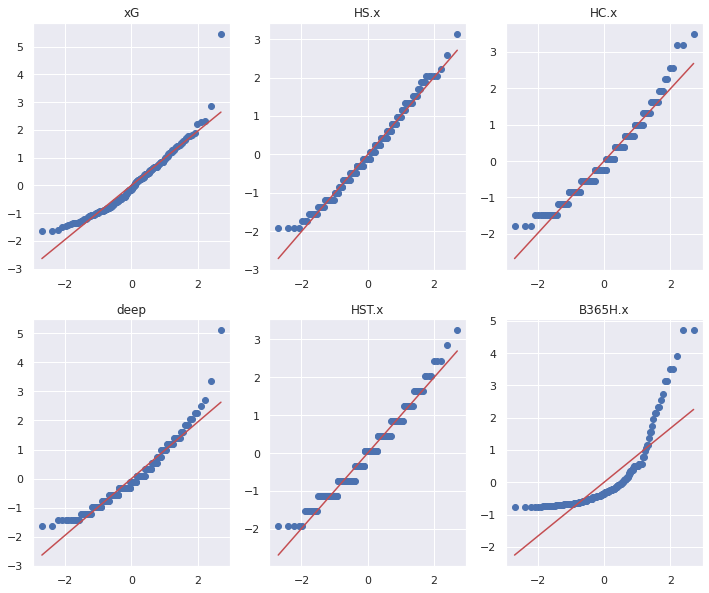

In [21]:
from scipy.stats import probplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,10))

for i, col in enumerate(X.columns):
  probplot(X[col], plot=ax[i%2, i//2])
  ax[i%2, i//2].set_ylabel('')
  ax[i%2, i//2].set_xlabel('')
  ax[i%2, i//2].set_title(col)

**Correlation Matrix**

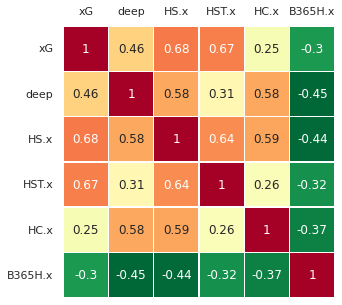

In [22]:
ax = sns.heatmap(X.corr(), cmap='RdYlGn_r', linewidths=0.5, annot=True, cbar=False, square=True)
plt.yticks(rotation=0)
ax.tick_params(labelbottom=False,labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0);

#X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)
#sns.clustermap(X.corr(), annot=True, fmt='.2f')

##**Principal Component Analysis (PCA)**

Text(0.5, 0, '$Z_3$')

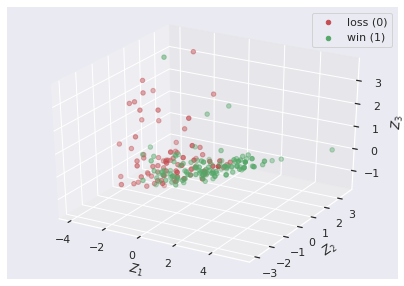

In [23]:
y = target
pca = PCA()
pca.fit(X)
Z = pca.fit_transform(X)

# (loss)->0, (win)->1
idx_loss = np.where(y == 0)
idx_win = np.where(y == 1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(Z[idx_loss,0], Z[idx_loss,1], Z[idx_loss,2], c='r', label='loss (0)')
ax.scatter(Z[idx_win,0], Z[idx_win,1], Z[idx_win,2], c='g', label='win (1)')
plt.legend()
plt.xlabel('$Z_1$')
plt.ylabel('$Z_2$')
ax.set_zlabel('$Z_3$')
#for label, x, y in zip(observations,Z[:, 0],Z[:, 1]):
#    plt.annotate(label, xy=(x, y), xytext=(-2, 2),
#        textcoords='offset points', ha='right', va='bottom')

**Distribution of PCs**

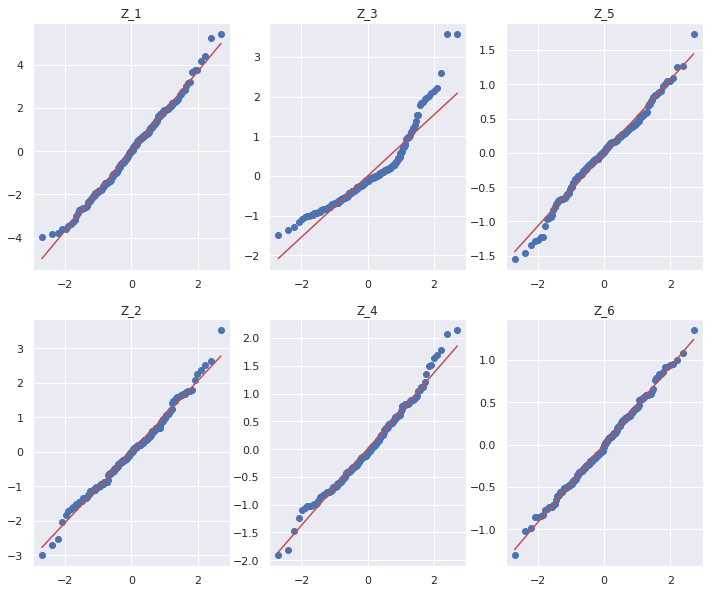

In [24]:
from scipy.stats import probplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,10))

for i, col in enumerate(X.columns):
  probplot(Z[:,i], plot=ax[i%2, i//2])
  ax[i%2, i//2].set_ylabel('')
  ax[i%2, i//2].set_xlabel('')
  ax[i%2, i//2].set_title('Z_{}'.format(i+1))

**Eigenvectors**

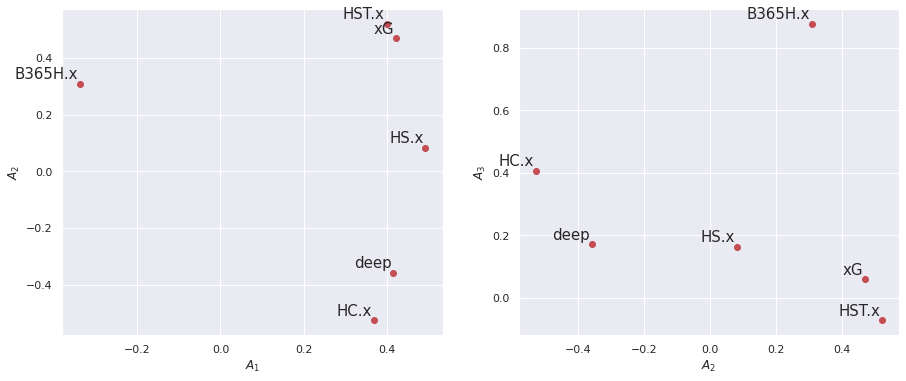

In [25]:
A = pca.components_.T 
#print(f'Eigenvector matrix:\n{A}')

fig, ax = plt.subplots(figsize=(15, 6), ncols=2)
ax[0].scatter(A[:,0],A[:,1],c='r')
ax[0].set_xlabel('$A_1$')
ax[0].set_ylabel('$A_2$')
for label, x, y in zip(variables, A[:, 0], A[:, 1]):
  ax[0].annotate(label, xy=(x, y), xytext=(-2, 2), textcoords='offset points', ha='right', va='bottom', fontsize=15)

ax[1].scatter(A[:,1],A[:,2],c='r')
ax[1].set_xlabel('$A_2$')
ax[1].set_ylabel('$A_3$')
for label, x, y in zip(variables, A[:, 1], A[:, 2]):
  ax[1].annotate(label, xy=(x, y), xytext=(-2, 2), textcoords='offset points', ha='right', va='bottom', fontsize=15)

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


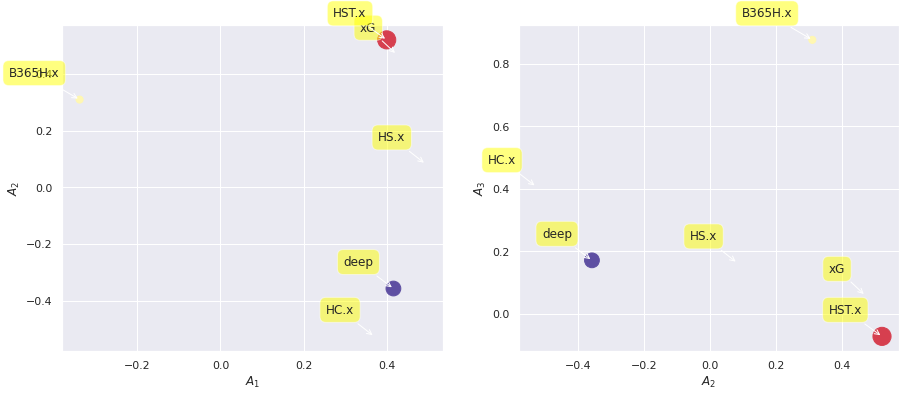

In [26]:
fig, ax = plt.subplots(figsize=(15, 6), ncols=2)
ax[0].scatter(A[:, 0],A[:, 1], marker='o', c=A[:, 3], s=A[:, 4]*500, cmap=plt.get_cmap('Spectral'))
ax[0].set_xlabel('$A_1$')
ax[0].set_ylabel('$A_2$')
for label, x, y in zip(variables,A[:, 0],A[:, 1]):
  ax[0].annotate(label,xy=(x, y), xytext=(-20, 20),
      textcoords='offset points', ha='right', va='bottom',
      bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
      arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  
ax[1].scatter(A[:,1],A[:,2], marker='o', c=A[:, 3], s=A[:, 4]*500, cmap=plt.get_cmap('Spectral'))
ax[1].set_xlabel('$A_2$')
ax[1].set_ylabel('$A_3$')
for label, x, y in zip(variables, A[:, 1], A[:, 2]):
  ax[1].annotate(label,xy=(x, y), xytext=(-20, 20),
      textcoords='offset points', ha='right', va='bottom',
      bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
      arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

**Scree plot**

Text(0, 0.5, 'Explained variance')

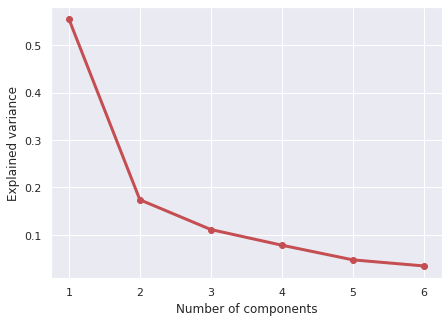

In [27]:
#Eigenvalues
Lambda = pca.explained_variance_ 

#Scree plot
x = np.arange(len(Lambda)) + 1
plt.plot(x,Lambda/sum(Lambda), 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance') 

**Explained Variance**

Text(0, 0.5, 'Cumulative explained variance')

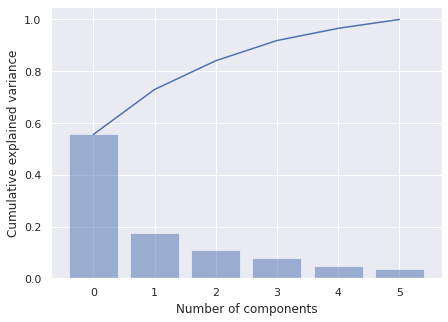

In [28]:
ell = pca.explained_variance_ratio_
ind = np.arange(len(ell))
plt.bar(ind, ell, align='center', alpha=0.5)
plt.plot(np.cumsum(ell))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

**Explained Variance per PC**

In [29]:
PC_variance = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
PC_variance

{'0': 'PC 1 (55.6%)',
 '1': 'PC 2 (17.4%)',
 '2': 'PC 3 (11.1%)',
 '3': 'PC 4 (7.8%)',
 '4': 'PC 5 (4.7%)',
 '5': 'PC 6 (3.4%)'}

**Biplot**

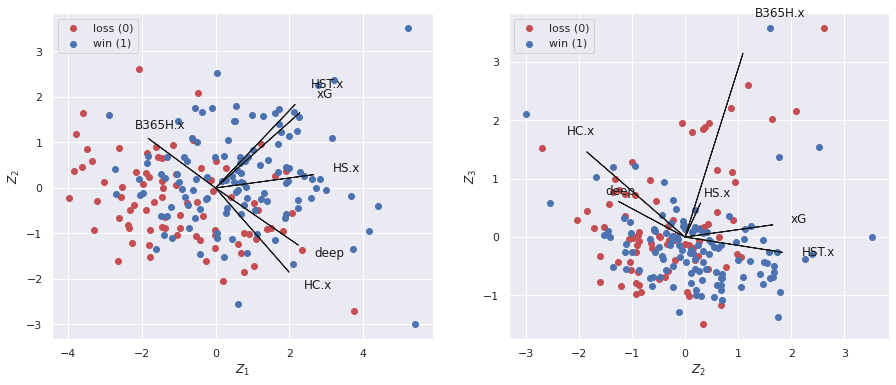

In [30]:
# 0,1 denote PC1 and PC2; change values for other PCs
A1 = A[:,0] 
A2 = A[:,1]
A3 = A[:,2]
Z1 = Z[:,0] 
Z2 = Z[:,1]
Z3 = Z[:,2]

fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].set_xlabel('$Z_1$')
ax[0].set_ylabel('$Z_2$')
for i in range(len(A1)):
# arrows project features as vectors onto PC axes
  ax[0].arrow(0, 0, A1[i]*max(Z1), A2[i]*max(Z2), color='k', width=0.0005, head_width=0.0025)
  ax[0].text(A1[i]*max(Z1)*1.2, A2[i]*max(Z2)*1.2,variables[i], color='k')

ax[0].scatter(Z[idx_loss,0], Z[idx_loss,1], c='r', label='loss (0)')
#plt.scatter(Z[idx_draw,0], Z[idx_draw,1], c='g', label='draw (1)')
ax[0].scatter(Z[idx_win,0], Z[idx_win,1], c='b', label='win (1)')
ax[0].legend(loc='upper left')
#for i in range(len(Z1)):
# circles project documents (ie rows from csv) as points onto PC axes
  #plt.scatter(Z1[i], Z2[i], c='g', marker='o')
  #plt.text(Z1[i]*1.2, Z2[i]*1.2, observations[i], color='b')

#plt.figure()
ax[1].set_xlabel('$Z_2$')
ax[1].set_ylabel('$Z_3$')
for i in range(len(A2)):
# arrows project features as vectors onto PC axes
  ax[1].arrow(0, 0, A2[i]*max(Z2), A3[i]*max(Z3), color='k', width=0.0005, head_width=0.0025)
  ax[1].text(A2[i]*max(Z2)*1.2, A3[i]*max(Z3)*1.2,variables[i], color='k')

ax[1].scatter(Z[idx_loss,1], Z[idx_loss,2], c='r', label='loss (0)')
ax[1].scatter(Z[idx_win,1], Z[idx_win,2], c='b', label='win (1)')
ax[1].legend(loc='upper left')

**Linear combination of features in components**

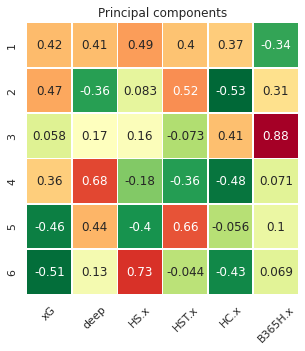

PC1:[ 0.42186726  0.41458576  0.49140837  0.3984906   0.36848269 -0.33777245]
PC2:[ 0.47015478 -0.35711543  0.08282687  0.52109607 -0.52611494  0.31020109]


In [31]:
comps = pd.DataFrame(A.T, columns = variables[:-1])
sns.heatmap(comps,cmap='RdYlGn_r', linewidths=0.5, annot=True, 
            cbar=False, square=True, yticklabels=range(1, 7))
#ax.tick_params(labelbottom=False,labeltop=True)
plt.xticks(rotation=45)
plt.title('Principal components')
plt.show()

print(f'PC1:{A1}')
print(f'PC2:{A2}')

##**Using PCA Library**

In [ ]:
!pip install pca

In [33]:
from pca import pca
# Initialize and keep all PCs
model = pca()
# Fit transform
out = model.fit_transform(X)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [6] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


**Principal Components**

In [34]:
out['PC']

PC1       PC2       PC3       PC4       PC5
0   -2.036356 -0.145030  0.005299 -0.589131 -0.667463
1   -1.457786  0.647952  0.008006  0.798426 -0.271734
2    0.334450  1.058451 -0.857358 -0.358744 -0.001076
3   -2.165801  0.344373  1.844024 -0.556107 -0.783810
4    0.765031 -0.365426  0.064648 -1.818604 -1.063825
..        ...       ...       ...       ...       ...
195  1.324351 -0.113387 -0.141707  0.450965  0.887408
196  1.624572  1.655340 -0.681647 -0.050540  0.151992
197  2.130380  1.672109 -0.492663  0.140305 -0.158145
198 -1.428082 -0.001944 -0.125606  0.042012  0.398654
199 -0.957926 -0.888985 -0.600015 -0.026415  0.103392

[200 rows x 5 columns]

**Scatter plot**

[colourmap]> Warning: Colormap [Set1] can not create [200] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [200] unique colors! Available unique colors: [9].


(<Figure size 1440x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1543327370>)

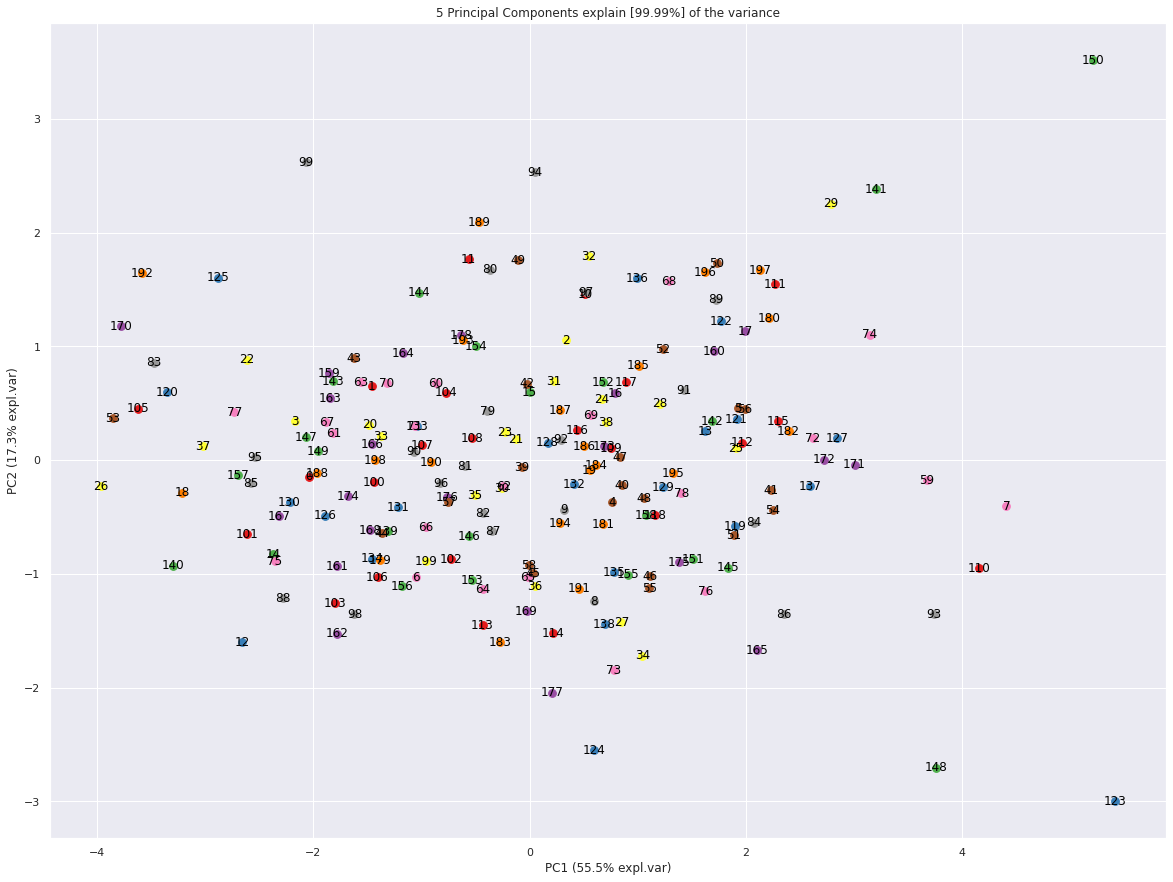

In [35]:
model.scatter(label=True, legend=False)

**Eigenvectors**

In [36]:
A = out['loadings'].T

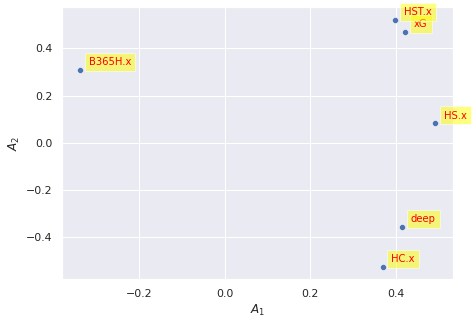

In [37]:
sns.scatterplot(data=A, x="PC1", y="PC2")
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for i in range(A.shape[0]):
 plt.text(x=A.PC1[i]+0.02,y=A.PC2[i]+0.02, s=variables[i],
          fontdict=dict(color='red',size=10),
          bbox=dict(facecolor='yellow',alpha=0.5))

**Scree Plot**

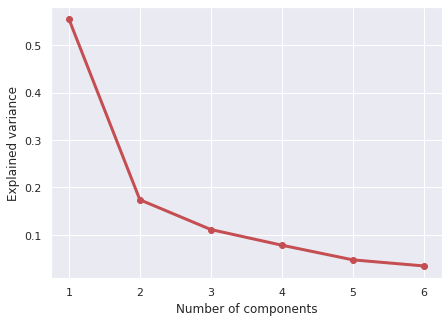

In [38]:
VR = out['variance_ratio']
x = np.arange(len(VR)) + 1
plt.plot(x, VR, 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance') 
plt.show()

**Explained Variance Plot**

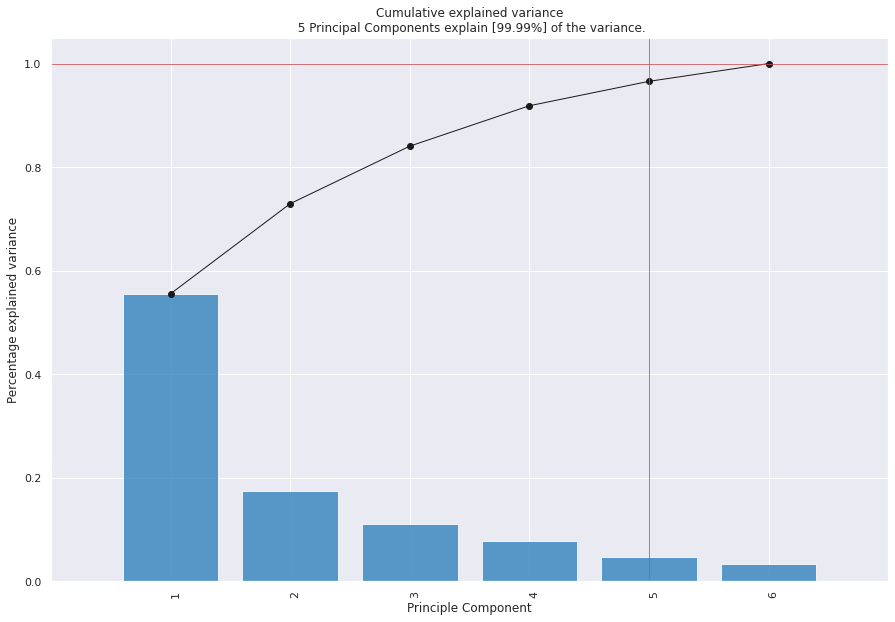

<Figure size 504x360 with 0 Axes>

In [39]:
model.plot();

**Biplot**

[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [200] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [200] unique colors! Available unique colors: [9].


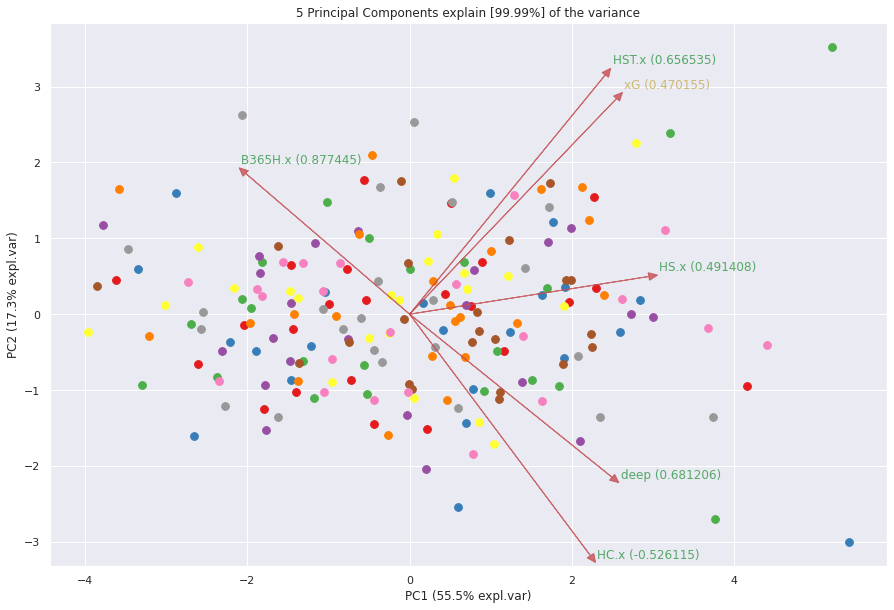

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f15462700a0>)

In [40]:
model.biplot(label=False, legend=False)

[pca] >Plot PC1 vs PC2 vs PC3 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [200] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [200] unique colors! Available unique colors: [9].


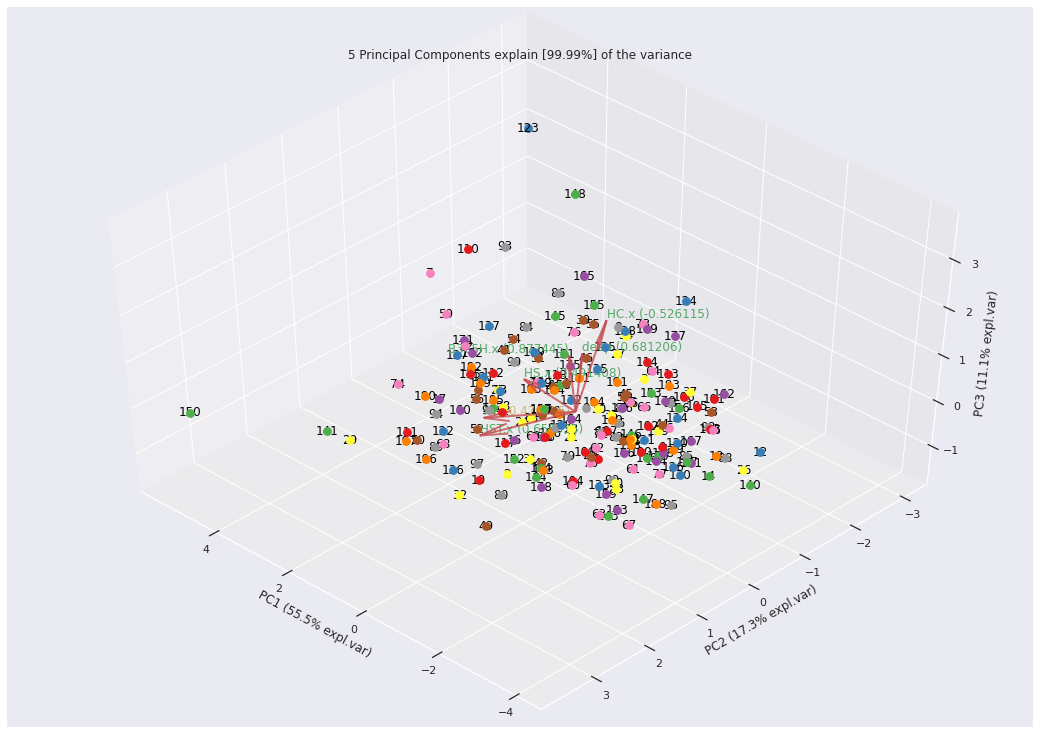

(<Figure size 1080x720 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f15413890d0>)

In [41]:
model.biplot3d(legend=False)

#**Classification**

**Using PyCaret**

PyCaret uses interactive plotting ability. In order to render interactive plots in Google Colab, run the below line of code in your colab notebook.

In [42]:
#For Google Colab only
from pycaret.utils import enable_colab 
enable_colab()

Colab mode enabled.


In order to demonstrate the predict_model() function on unseen data, a sample of 21 observations has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 21 records were not available at the time when the machine learning experiment was performed.

In [43]:
data = df.sample(frac=0.7, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (140, 7)
Unseen Data For Predictions: (60, 7)


**Setting up the Environment in PyCaret**

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline (we will see them in later tutorials).

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In [44]:
from pycaret.classification import *
clf = setup(data=data, target='result', train_size=0.7, session_id=123)

Description             Value
0                               session_id               123
1                                   Target            result
2                              Target Type            Binary
3                            Label Encoded        l: 0, w: 1
4                            Original Data          (140, 7)
5                           Missing Values             False
6                         Numeric Features                 3
7                     Categorical Features                 3
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set          (97, 50)
12                    Transformed Test Set          (43, 50)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              abae
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance             False
59                    Fix Imbalance Method             SMOTE

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='result',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

Once the setup has been succesfully executed it prints the information grid which contains several important pieces of information. Most of the information is related to the pre-processing pipeline which is constructed when setup() is executed. The majority of these features are out of scope for the purposes of this tutorial however a few important things to note at this stage include:

* **session_id** : A pseduo-random number distributed as a seed in all functions for later reproducibility. If no session_id is passed, a random number is automatically generated that is distributed to all functions. In this experiment, the session_id is set as 123 for later reproducibility.

* **Target Type** : Binary or Multiclass. The Target type is automatically detected and shown. There is no difference in how the experiment is performed for Binary or Multiclass problems. All functionalities are identical.

* **Label Encoded** : When the Target variable is of type string (i.e. 'Yes' or 'No') instead of 1 or 0, it automatically encodes the label into 1 and 0 and displays the mapping (0 : No, 1 : Yes) for reference. 

* **Original Data** : Displays the original shape of the dataset. In this experiment (189, 8) means 189 samples and 8 features including the class column.

* **Missing Values** : When there are missing values in the original data this will show as True. For this experiment there are no missing values in the dataset.

* **Numeric Features** : The number of features inferred as numeric. In this dataset, 7 out of 8 features are inferred as numeric.

* **Categorical Features** : The number of features inferred as categorical. In this dataset, there are no categorical features.

* **Transformed Train Set** : Displays the shape of the transformed training set. Notice that the original shape of (189, 8) is transformed into (132, 7) for the transformed train set.

* **Transformed Test Set** : Displays the shape of the transformed test/hold-out set. There are 57 samples in test/hold-out set. This split is based on the default value of 70/30 that can be changed using the train_size parameter in setup.

Notice how a few tasks that are imperative to perform modeling are automatically handled such as missing value imputation, categorical encoding etc. Most of the parameters in setup() are optional and used for customizing the pre-processing pipeline. 

**Comparing All Models**

In [45]:
 #show the best model and their statistics
 best_model = compare_models() 

Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.7711  0.8080  0.8762  0.8028   
rf               Random Forest Classifier    0.7600  0.8017  0.8762  0.8031   
lightgbm  Light Gradient Boosting Machine    0.7522  0.7837  0.8357  0.8155   
lr                    Logistic Regression    0.7289  0.8111  0.8476  0.7808   
dt               Decision Tree Classifier    0.7200  0.6762  0.8024  0.7987   
svm                   SVM - Linear Kernel    0.7100  0.0000  0.8357  0.8042   
gbc          Gradient Boosting Classifier    0.7000  0.7881  0.8024  0.7824   
ada                  Ada Boost Classifier    0.6989  0.7129  0.7714  0.8050   
knn                K Neighbors Classifier    0.6911  0.7498  0.8500  0.7415   
ridge                    Ridge Classifier    0.6889  0.0000  0.8024  0.7827   
dummy                    Dummy Classifier    0.6800  0.5000  1.0000  0.6800   
lda          Linear Discriminant Analysis    0.6500  0.7002  0.7167  0.7925   
nb                            Naive Bayes    0.5167  0.6556  0.3976  0.7967   
qda       Quadratic Discriminant Analysis    0.3933  0.5179  0.1690  0.1464   

              F1   Kappa     MCC  TT (Sec)  
et        0.8353  0.4538  0.4742     0.147  
rf        0.8297  0.4026  0.4329     0.185  
lightgbm  0.8162  0.4254  0.4607     0.098  
lr        0.8040  0.3434  0.3707     0.305  
dt        0.7919  0.3499  0.3755     0.012  
svm       0.7684  0.2936  0.3244     0.010  
gbc       0.7784  0.2868  0.3144     0.057  
ada       0.7688  0.2992  0.3214     0.113  
knn       0.7848  0.2105  0.2254     0.019  
ridge     0.7709  0.2299  0.2566     0.010  
dummy     0.8091  0.0000  0.0000     0.009  
lda       0.7280  0.1945  0.2105     0.012  
nb        0.5219  0.1341  0.1682     0.014  
qda       0.1569  0.0392  0.0407     0.014

INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [46]:
best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

**Create a Model**

create_model is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows Accuracy, Recall, Precision, F1, Kappa and MCC by fold.

For the remaining part of this tutorial, we will work with the below models as our candidate models. The initial selection we not based on model performance, it was of special interest to us to view how PCA improved these three algorithms, as we explain in the report.

* Gaussian Naive Bayes ('nb')
* Decision Tree Classifier ('dt')
* Logistic Regression ('lr')

There are many classifiers available in the model library of PyCaret. Please view the create_model() docstring for the list of all available models.

**Create Gaussian Naive Bayes Model**

In [47]:
nb = create_model('nb')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6000  0.8571  0.4286  1.0000  0.6000  0.3103  0.4286
1       0.3000  0.2619  0.1429  0.5000  0.2222 -0.1290 -0.2182
2       0.3000  0.4286  0.2857  0.5000  0.3636 -0.2963 -0.3563
3       0.4000  0.7143  0.2857  0.6667  0.4000 -0.0345 -0.0476
4       0.6000  0.7143  0.5714  0.8000  0.6667  0.2000  0.2182
5       0.6000  0.8571  0.4286  1.0000  0.6000  0.3103  0.4286
6       0.7000  0.6667  0.5000  1.0000  0.6667  0.4444  0.5345
7       0.5556  0.6667  0.3333  1.0000  0.5000  0.2500  0.3780
8       0.7778  0.9444  0.6667  1.0000  0.8000  0.5714  0.6325
9       0.3333  0.4444  0.3333  0.5000  0.4000 -0.2857 -0.3162
Mean    0.5167  0.6556  0.3976  0.7967  0.5219  0.1341  0.1682
SD      0.1629  0.2057  0.1460  0.2208  0.1663  0.2875  0.3518

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:GaussianNB(priors=None, var_smoothing=1e-09)
INFO:logs:create_model() succesfully completed......................................


**Tune Gaussian Naive Bayes Model**

In [48]:
tuned_nb = tune_model(nb)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9000  0.8095  1.0000  0.8750  0.9333  0.7368  0.7638
1       0.7000  0.5238  0.7143  0.8333  0.7692  0.3478  0.3563
2       0.8000  0.8571  0.8571  0.8571  0.8571  0.5238  0.5238
3       0.7000  0.8095  0.7143  0.8333  0.7692  0.3478  0.3563
4       0.8000  0.8095  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.9000  1.0000  1.0000  0.8750  0.9333  0.7368  0.7638
6       0.7000  0.8750  0.8333  0.7143  0.7692  0.3478  0.3563
7       0.5556  0.6667  0.6667  0.6667  0.6667  0.0000  0.0000
8       0.7778  0.9444  0.8333  0.8333  0.8333  0.5000  0.5000
9       0.6667  0.6667  1.0000  0.6667  0.8000  0.0000  0.0000
Mean    0.7500  0.7962  0.8333  0.8155  0.8165  0.4141  0.4275
SD      0.1015  0.1348  0.1242  0.0992  0.0768  0.2487  0.2594

INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:GaussianNB(priors=None, var_smoothing=0.007)
INFO:logs:tune_model() succesfully completed......................................


**Evaluate Gaussian Naive Bayes Model**

In [49]:
evaluate_model(tuned_nb)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=GaussianNB(priors=None, var_smoothing=0.007), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Create Decision Tree Classifier**

In [50]:
dt = create_model('dt')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.5952  0.8571  0.7500  0.8000  0.2105  0.2182
1       0.6000  0.5238  0.7143  0.7143  0.7143  0.0476  0.0476
2       0.7000  0.5952  0.8571  0.7500  0.8000  0.2105  0.2182
3       0.8000  0.8571  0.7143  1.0000  0.8333  0.6000  0.6547
4       0.8000  0.8571  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.9000  0.8333  1.0000  0.8750  0.9333  0.7368  0.7638
6       0.7000  0.6667  0.8333  0.7143  0.7692  0.3478  0.3563
7       0.4444  0.4167  0.5000  0.6000  0.5455 -0.1538 -0.1581
8       0.7778  0.7500  0.8333  0.8333  0.8333  0.5000  0.5000
9       0.7778  0.6667  1.0000  0.7500  0.8571  0.4000  0.5000
Mean    0.7200  0.6762  0.8024  0.7987  0.7919  0.3499  0.3755
SD      0.1198  0.1412  0.1417  0.1220  0.0984  0.2615  0.2792

INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 5
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
INFO:logs:create_model() succesfully completed......................................


In [51]:
#trained model object is stored in the variable 'dt'. 
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

**Tune a Model:** How to automatically tune the hyper-parameters of a multiclass model. When a model is created using the create_model() function it uses the default hyperparameters. In order to tune hyperparameters, the tune_model() function is used. The tune_model() function is a random grid search of hyperparameters over a pre-defined search space. By default, it is set to optimize Accuracy but this can be changed using optimize parameter. This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold.

**Tune Decision Tree Model**

In [52]:
tuned_dt = tune_model(dt)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6000  0.4048  0.5714  0.8000  0.6667  0.2000  0.2182
1       0.8000  0.7619  0.8571  0.8571  0.8571  0.5238  0.5238
2       0.9000  0.9762  0.8571  1.0000  0.9231  0.7826  0.8018
3       0.9000  1.0000  0.8571  1.0000  0.9231  0.7826  0.8018
4       0.8000  0.8333  0.8571  0.8571  0.8571  0.5238  0.5238
5       0.9000  0.9524  0.8571  1.0000  0.9231  0.7826  0.8018
6       0.7000  0.7708  0.6667  0.8000  0.7273  0.4000  0.4082
7       0.4444  0.3611  0.5000  0.6000  0.5455 -0.1538 -0.1581
8       0.6667  0.6389  0.8333  0.7143  0.7692  0.1818  0.1890
9       0.7778  0.8333  1.0000  0.7500  0.8571  0.4000  0.5000
Mean    0.7489  0.7533  0.7857  0.8379  0.8049  0.4423  0.4610
SD      0.1409  0.2125  0.1468  0.1273  0.1199  0.2909  0.2961

INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
INFO:logs:tune_model() succesfully completed......................................


In [53]:
#tuned model object is stored in the variable 'tuned_dt'. 
tuned_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

**Evaluate Decision Tree Model**

Update statmodels

In [54]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


How to analyze model performance using various plots

In [55]:
evaluate_model(tuned_dt)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best'), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…



```
# This is formatted as code
```

**Create Logistic Regression Model**

In [56]:
lr = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9000  0.8571  1.0000  0.8750  0.9333  0.7368  0.7638
1       0.7000  0.5714  0.7143  0.8333  0.7692  0.3478  0.3563
2       0.7000  0.9524  1.0000  0.7000  0.8235  0.0000  0.0000
3       0.9000  0.8571  0.8571  1.0000  0.9231  0.7826  0.8018
4       0.6000  0.7619  0.5714  0.8000  0.6667  0.2000  0.2182
5       0.8000  1.0000  1.0000  0.7778  0.8750  0.4118  0.5092
6       0.8000  0.8333  1.0000  0.7500  0.8571  0.5455  0.6124
7       0.3333  0.5000  0.5000  0.5000  0.5000 -0.5000 -0.5000
8       0.8889  0.9444  1.0000  0.8571  0.9231  0.7273  0.7559
9       0.6667  0.8333  0.8333  0.7143  0.7692  0.1818  0.1890
Mean    0.7289  0.8111  0.8476  0.7808  0.8040  0.3434  0.3707
SD      0.1652  0.1534  0.1820  0.1252  0.1292  0.3764  0.3897

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 7
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:create_model() succesfully completed......................................


**Tune Logistic Regression Model**

In [57]:
tuned_lr = tune_model(lr)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.8571  0.7143  0.8333  0.7692  0.3478  0.3563
1       0.7000  0.6667  0.7143  0.8333  0.7692  0.3478  0.3563
2       0.7000  0.9048  0.8571  0.7500  0.8000  0.2105  0.2182
3       0.7000  0.8571  0.5714  1.0000  0.7273  0.4444  0.5345
4       0.7000  0.8095  0.5714  1.0000  0.7273  0.4444  0.5345
5       1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
6       0.8000  0.9167  0.6667  1.0000  0.8000  0.6154  0.6667
7       0.4444  0.5000  0.5000  0.6000  0.5455 -0.1538 -0.1581
8       0.8889  0.9444  1.0000  0.8571  0.9231  0.7273  0.7559
9       0.7778  0.8333  0.8333  0.8333  0.8333  0.5000  0.5000
Mean    0.7411  0.8290  0.7429  0.8707  0.7895  0.4484  0.4764
SD      0.1379  0.1388  0.1669  0.1261  0.1151  0.2919  0.2990

INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 8
INFO:logs:LogisticRegression(C=0.472, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


**Evaluate Logistic Regression Model**

In [58]:
evaluate_model(tuned_lr)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LogisticRegression(C=0.472, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#**Tune the Best Model**

In [59]:
# Tune hyperparameters with scikit-learn (default)
tuned_best_model = tune_model(best_model)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.8571  0.7143  0.8333  0.7692  0.3478  0.3563
1       0.7000  0.5238  0.7143  0.8333  0.7692  0.3478  0.3563
2       0.6000  0.6190  0.7143  0.7143  0.7143  0.0476  0.0476
3       0.9000  0.9048  0.8571  1.0000  0.9231  0.7826  0.8018
4       0.7000  0.8095  0.5714  1.0000  0.7273  0.4444  0.5345
5       0.9000  0.7619  1.0000  0.8750  0.9333  0.7368  0.7638
6       0.7000  0.7917  0.8333  0.7143  0.7692  0.3478  0.3563
7       0.6667  0.6111  0.8333  0.7143  0.7692  0.1818  0.1890
8       0.8889  0.8889  0.8333  1.0000  0.9091  0.7692  0.7906
9       0.8889  0.6667  1.0000  0.8571  0.9231  0.7273  0.7559
Mean    0.7644  0.7435  0.8071  0.8542  0.8207  0.4733  0.4952
SD      0.1100  0.1242  0.1266  0.1113  0.0849  0.2513  0.2598

INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 9
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0005,
                     min_impurity_split=None, min_samples_leaf=3,
                     min_samples_split=5, min_weight_fraction_leaf=0.0,
                     n_estimators=260, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [60]:
tuned_best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0005,
                     min_impurity_split=None, min_samples_leaf=3,
                     min_samples_split=5, min_weight_fraction_leaf=0.0,
                     n_estimators=260, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)

**Evaluate the Best Model**

One way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [61]:
evaluate_model(tuned_best_model)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0005,
                     min_impurity_split=None, min_samples_leaf=3,
                     min_samples_split=5, min_weight_fraction_leaf=0.0,
                     n_estimators=260, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#**Classification + PCA**

In [62]:
clf_pca = setup(data=data, target='result', train_size=0.7, session_id=123, normalize = True, pca = True, pca_components = 3)

Description             Value
0                               session_id               123
1                                   Target            result
2                              Target Type            Binary
3                            Label Encoded        l: 0, w: 1
4                            Original Data          (140, 7)
5                           Missing Values             False
6                         Numeric Features                 3
7                     Categorical Features                 3
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set           (97, 3)
12                    Transformed Test Set           (43, 3)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              99ef
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize              True
30                        Normalize Method            zscore
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA              True
34                              PCA Method            linear
35                          PCA Components                 3
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance             False
59                    Fix Imbalance Method             SMOTE

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='result',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('dummy', Dummify(target='result')),
                ('fix_perfect', Remove_100(target='result')),
                ('clean_names', Clean_Colum_Names()),
     

In [63]:
#show the best model and their statistics
best_model_pca = compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.7811  0.8325  0.8952  0.8187   
lda          Linear Discriminant Analysis    0.7800  0.8437  0.8786  0.8217   
qda       Quadratic Discriminant Analysis    0.7722  0.8244  0.9095  0.7964   
svm                   SVM - Linear Kernel    0.7611  0.0000  0.8357  0.8314   
ridge                    Ridge Classifier    0.7600  0.0000  0.8952  0.8008   
nb                            Naive Bayes    0.7511  0.8435  0.8952  0.7912   
gbc          Gradient Boosting Classifier    0.7489  0.7813  0.8167  0.8200   
knn                K Neighbors Classifier    0.7211  0.7931  0.8500  0.7777   
et                 Extra Trees Classifier    0.7200  0.7911  0.8024  0.7933   
rf               Random Forest Classifier    0.7100  0.7800  0.7905  0.7873   
lightgbm  Light Gradient Boosting Machine    0.7078  0.7841  0.8024  0.7849   
ada                  Ada Boost Classifier    0.6878  0.7954  0.7881  0.7671   
dummy                    Dummy Classifier    0.6800  0.5000  1.0000  0.6800   
dt               Decision Tree Classifier    0.6767  0.6506  0.7262  0.7944   

              F1   Kappa     MCC  TT (Sec)  
lr        0.8459  0.4599  0.5135     0.012  
lda       0.8396  0.4770  0.5231     0.014  
qda       0.8420  0.4242  0.4793     0.015  
svm       0.8243  0.4380  0.4533     0.011  
ridge     0.8350  0.3976  0.4553     0.011  
nb        0.8283  0.3759  0.4073     0.012  
gbc       0.8031  0.4400  0.4806     0.055  
knn       0.8033  0.3142  0.3446     0.018  
et        0.7853  0.3677  0.4028     0.158  
rf        0.7758  0.3434  0.3764     0.189  
lightgbm  0.7875  0.3045  0.3178     0.037  
ada       0.7654  0.2759  0.3117     0.077  
dummy     0.8091  0.0000  0.0000     0.012  
dt        0.7446  0.2911  0.3225     0.012

INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [64]:
best_model_pca

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluating GNB, DT and LR**

**Create Gaussian Naive Bayes Model**

In [65]:
nb = create_model('nb')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9000  0.8571  1.0000  0.8750  0.9333  0.7368  0.7638
1       0.8000  0.7143  0.8571  0.8571  0.8571  0.5238  0.5238
2       0.8000  0.9524  1.0000  0.7778  0.8750  0.4118  0.5092
3       0.7000  0.7619  0.7143  0.8333  0.7692  0.3478  0.3563
4       0.8000  0.9048  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.8000  0.9524  1.0000  0.7778  0.8750  0.4118  0.5092
6       0.6000  0.9583  1.0000  0.6000  0.7500  0.0000  0.0000
7       0.5556  0.6667  0.6667  0.6667  0.6667  0.0000  0.0000
8       0.8889  0.9444  1.0000  0.8571  0.9231  0.7273  0.7559
9       0.6667  0.7222  1.0000  0.6667  0.8000  0.0000  0.0000
Mean    0.7511  0.8435  0.8952  0.7912  0.8283  0.3759  0.4073
SD      0.1102  0.1097  0.1360  0.1136  0.0786  0.2744  0.2906

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:GaussianNB(priors=None, var_smoothing=1e-09)
INFO:logs:create_model() succesfully completed......................................


**Tune Gaussian Naive Bayes Model**

In [66]:
tuned_nb = tune_model(nb)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9000  0.8571  1.0000  0.8750  0.9333  0.7368  0.7638
1       0.8000  0.7143  0.8571  0.8571  0.8571  0.5238  0.5238
2       0.8000  0.9524  1.0000  0.7778  0.8750  0.4118  0.5092
3       0.7000  0.7619  0.7143  0.8333  0.7692  0.3478  0.3563
4       0.8000  0.9048  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.8000  0.9524  1.0000  0.7778  0.8750  0.4118  0.5092
6       0.6000  0.9583  1.0000  0.6000  0.7500  0.0000  0.0000
7       0.5556  0.6667  0.6667  0.6667  0.6667  0.0000  0.0000
8       0.8889  0.9444  1.0000  0.8571  0.9231  0.7273  0.7559
9       0.6667  0.7222  1.0000  0.6667  0.8000  0.0000  0.0000
Mean    0.7511  0.8435  0.8952  0.7912  0.8283  0.3759  0.4073
SD      0.1102  0.1097  0.1360  0.1136  0.0786  0.2744  0.2906

INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:GaussianNB(priors=None, var_smoothing=2e-09)
INFO:logs:tune_model() succesfully completed......................................


**Evaluate Gaussian Naive Bayes Model**

In [67]:
evaluate_model(tuned_nb)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=GaussianNB(priors=None, var_smoothing=2e-09), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Create Decision Tree Classifier**

In [68]:
dt = create_model('dt')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.7857  0.5714  1.0000  0.7273  0.4444  0.5345
1       0.6000  0.5238  0.7143  0.7143  0.7143  0.0476  0.0476
2       0.9000  0.8333  1.0000  0.8750  0.9333  0.7368  0.7638
3       0.7000  0.6905  0.7143  0.8333  0.7692  0.3478  0.3563
4       0.7000  0.7857  0.5714  1.0000  0.7273  0.4444  0.5345
5       0.8000  0.7619  0.8571  0.8571  0.8571  0.5238  0.5238
6       0.7000  0.7083  0.6667  0.8000  0.7273  0.4000  0.4082
7       0.2222  0.1667  0.3333  0.4000  0.3636 -0.6154 -0.6325
8       0.6667  0.5833  0.8333  0.7143  0.7692  0.1818  0.1890
9       0.7778  0.6667  1.0000  0.7500  0.8571  0.4000  0.5000
Mean    0.6767  0.6506  0.7262  0.7944  0.7446  0.2911  0.3225
SD      0.1703  0.1850  0.1961  0.1634  0.1446  0.3492  0.3702

INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 5
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
INFO:logs:create_model() succesfully completed......................................


In [69]:
#trained model object is stored in the variable 'dt'. 
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

**Tune a Model:** How to automatically tune the hyper-parameters of a multiclass model. When a model is created using the create_model() function it uses the default hyperparameters. In order to tune hyperparameters, the tune_model() function is used. The tune_model() function is a random grid search of hyperparameters over a pre-defined search space. By default, it is set to optimize Accuracy but this can be changed using optimize parameter. This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold.

**Tune Decision Tree Model**

In [70]:
tuned_dt = tune_model(dt)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.5238  0.8571  0.7500  0.8000  0.2105  0.2182
1       0.6000  0.4048  0.7143  0.7143  0.7143  0.0476  0.0476
2       0.7000  0.9524  1.0000  0.7000  0.8235  0.0000  0.0000
3       1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
4       0.8000  0.7619  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.8000  0.8571  0.8571  0.8571  0.8571  0.5238  0.5238
6       0.8000  0.7708  1.0000  0.7500  0.8571  0.5455  0.6124
7       0.6667  0.5000  0.8333  0.7143  0.7692  0.1818  0.1890
8       0.8889  0.9167  1.0000  0.8571  0.9231  0.7273  0.7559
9       0.7778  0.8889  1.0000  0.7500  0.8571  0.4000  0.5000
Mean    0.7733  0.7576  0.8976  0.8093  0.8435  0.4237  0.4502
SD      0.1091  0.1987  0.1127  0.1086  0.0748  0.3009  0.3096

INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
INFO:logs:tune_model() succesfully completed......................................


In [71]:
#tuned model object is stored in the variable 'tuned_dt'. 
tuned_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

**Evaluate Decision Tree Model**

In [72]:
evaluate_model(tuned_dt)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best'), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…



```
# This is formatted as code
```

**Create Logistic Regression Model**

In [73]:
lr = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8000  0.8571  0.8571  0.8571  0.8571  0.5238  0.5238
1       0.8000  0.6667  0.8571  0.8571  0.8571  0.5238  0.5238
2       0.8000  0.9048  1.0000  0.7778  0.8750  0.4118  0.5092
3       0.9000  0.8571  0.8571  1.0000  0.9231  0.7826  0.8018
4       0.8000  0.8095  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.8000  0.9524  1.0000  0.7778  0.8750  0.4118  0.5092
6       0.8000  1.0000  1.0000  0.7500  0.8571  0.5455  0.6124
7       0.5556  0.5556  0.6667  0.6667  0.6667  0.0000  0.0000
8       0.7778  0.9444  1.0000  0.7500  0.8571  0.4000  0.5000
9       0.7778  0.7778  1.0000  0.7500  0.8571  0.4000  0.5000
Mean    0.7811  0.8325  0.8952  0.8187  0.8459  0.4599  0.5135
SD      0.0820  0.1300  0.1201  0.1046  0.0637  0.1904  0.1942

INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 7
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:create_model() succesfully completed......................................


**Tune Logistic Regression Model**

In [74]:
tuned_lr = tune_model(lr)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8000  0.8571  0.8571  0.8571  0.8571  0.5238  0.5238
1       0.8000  0.7143  0.8571  0.8571  0.8571  0.5238  0.5238
2       0.8000  0.9048  1.0000  0.7778  0.8750  0.4118  0.5092
3       0.9000  0.9048  0.8571  1.0000  0.9231  0.7826  0.8018
4       0.8000  0.8095  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.9000  0.9524  1.0000  0.8750  0.9333  0.7368  0.7638
6       0.9000  1.0000  1.0000  0.8571  0.9231  0.7826  0.8018
7       0.4444  0.5000  0.5000  0.6000  0.5455 -0.1538 -0.1581
8       0.7778  0.9444  1.0000  0.7500  0.8571  0.4000  0.5000
9       0.7778  0.8333  1.0000  0.7500  0.8571  0.4000  0.5000
Mean    0.7900  0.8421  0.8786  0.8324  0.8462  0.5008  0.5421
SD      0.1251  0.1379  0.1567  0.1142  0.1055  0.2612  0.2631

INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 8
INFO:logs:LogisticRegression(C=7.863, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


**Evaluate Logistic Regression Model**

In [75]:
evaluate_model(tuned_lr)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LogisticRegression(C=7.863, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Tune the Best Model**

In [76]:
# Tune hyperparameters with scikit-learn (default)
tuned_best_model_pca = tune_model(best_model_pca)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8000  0.8571  0.8571  0.8571  0.8571  0.5238  0.5238
1       0.8000  0.7143  0.8571  0.8571  0.8571  0.5238  0.5238
2       0.8000  0.9048  1.0000  0.7778  0.8750  0.4118  0.5092
3       0.9000  0.9048  0.8571  1.0000  0.9231  0.7826  0.8018
4       0.8000  0.8095  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.9000  0.9524  1.0000  0.8750  0.9333  0.7368  0.7638
6       0.9000  1.0000  1.0000  0.8571  0.9231  0.7826  0.8018
7       0.4444  0.5000  0.5000  0.6000  0.5455 -0.1538 -0.1581
8       0.7778  0.9444  1.0000  0.7500  0.8571  0.4000  0.5000
9       0.7778  0.8333  1.0000  0.7500  0.8571  0.4000  0.5000
Mean    0.7900  0.8421  0.8786  0.8324  0.8462  0.5008  0.5421
SD      0.1251  0.1379  0.1567  0.1142  0.1055  0.2612  0.2631

INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 9
INFO:logs:LogisticRegression(C=7.863, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [77]:
tuned_best_model_pca

LogisticRegression(C=7.863, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Evaluate the Best Model**

One way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [78]:
evaluate_model(tuned_best_model_pca)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LogisticRegression(C=7.863, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Note:** The AUC metric is not available for Multiclass classification however the column will still be shown with zero values to maintain consistency between the Binary Classification and Multiclass Classification display grids.

**F1-score graphic comparison**

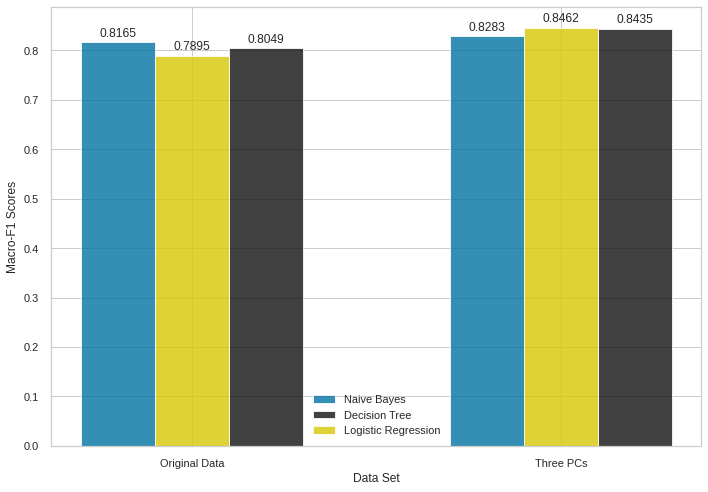

In [79]:
# ADAPTED FROM: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html

sns.set_context('notebook')
def autolabel(rects):
    for r in rects:
        height = r.get_height()
        ax.annotate(f'{height}', xy=(r.get_x() + r.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

n_groups = 2
ind = np.arange(n_groups)

# F1 Scores from above
NB = (0.8165, 0.8283)
DT = (0.8049, 0.8435)
LR = (0.7895, 0.8462)

# create plot
fig, ax = plt.subplots(figsize=(10,7))
index = np.arange(n_groups)
bar_width = 0.20
opacity = 0.8

rects1 = plt.bar(index, NB, bar_width, alpha=opacity, color='b', label='Naive Bayes')
rects3 = plt.bar(index + bar_width*2, DT, bar_width, alpha=opacity, color='k', label='Decision Tree')
rects2 = plt.bar(index + bar_width, LR, bar_width, alpha=opacity, color='y', label='Logistic Regression')

ax.set_xlabel('Data Set')
ax.set_ylabel('Macro-F1 Scores')
#plt.title(f'')
plt.xticks(index + bar_width, ('Original Data', 'Three PCs'))
plt.legend(loc="top right")

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

#**Explainable AI with Shapley values**

Shapley values are a widely used approach from cooperative game theory that come with desirable properties.

In [80]:
!pip install shap

In [84]:
print("Numpy version: ", np.__version__)

Numpy version:  1.21.6


In [82]:
!pip install numba==0.53

In [83]:
import shap

In [85]:
rf_pca = create_model('rf')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.8571  0.5714  1.0000  0.7273  0.4444  0.5345
1       0.6000  0.5714  0.7143  0.7143  0.7143  0.0476  0.0476
2       0.8000  0.9524  1.0000  0.7778  0.8750  0.4118  0.5092
3       0.7000  0.8571  0.7143  0.8333  0.7692  0.3478  0.3563
4       0.7000  0.8095  0.7143  0.8333  0.7692  0.3478  0.3563
5       0.7000  0.9048  0.8571  0.7500  0.8000  0.2105  0.2182
6       0.9000  0.9583  1.0000  0.8571  0.9231  0.7826  0.8018
7       0.3333  0.2222  0.3333  0.5000  0.4000 -0.2857 -0.3162
8       0.8889  0.7500  1.0000  0.8571  0.9231  0.7273  0.7559
9       0.7778  0.9167  1.0000  0.7500  0.8571  0.4000  0.5000
Mean    0.7100  0.7800  0.7905  0.7873  0.7758  0.3434  0.3764
SD      0.1534  0.2154  0.2132  0.1225  0.1442  0.2931  0.3157

INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 10
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [86]:
tuned_rf_pca = tune_model(rf_pca)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.9048  0.7143  0.8333  0.7692  0.3478  0.3563
1       0.7000  0.6190  0.7143  0.8333  0.7692  0.3478  0.3563
2       0.9000  0.9524  1.0000  0.8750  0.9333  0.7368  0.7638
3       0.8000  1.0000  0.7143  1.0000  0.8333  0.6000  0.6547
4       0.8000  0.7619  0.7143  1.0000  0.8333  0.6000  0.6547
5       0.9000  0.9048  1.0000  0.8750  0.9333  0.7368  0.7638
6       0.9000  0.9167  0.8333  1.0000  0.9091  0.8000  0.8165
7       0.5556  0.3889  0.6667  0.6667  0.6667  0.0000  0.0000
8       0.8889  0.8889  1.0000  0.8571  0.9231  0.7273  0.7559
9       0.6667  0.7778  0.8333  0.7143  0.7692  0.1818  0.1890
Mean    0.7811  0.8115  0.8190  0.8655  0.8340  0.5078  0.5311
SD      0.1148  0.1758  0.1287  0.1091  0.0860  0.2590  0.2704

INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 11
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


**SHAP Summary Plot**

Rather than using a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. 

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False), use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


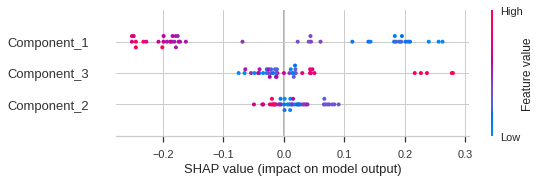

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [87]:
interpret_model(tuned_rf_pca, plot='summary')

**Visualize a single prediction**

In [89]:
interpret_model(tuned_rf_pca, plot='reason', observation=32)

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False), use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=32, plot=reason, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: reason
INFO:logs:model type detected: type 1
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values
INFO:logs:model type detected: Unknown


INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


From the above the plot, we can seethe "base value," which is defined as the mean predicted target; and f(x), which is the prediction for a selected observation (i.e. observation number 32). The red-colored features increased the predicted value, while the blue-colored features decreased it. The size of each feature (i.e. Principal Component) indicates the impact it has on the model.

**Visualize many predictions**

In [90]:
interpret_model(tuned_rf_pca, plot='reason')

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=4, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0002,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=130, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False), use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=None, plot=reason, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: reason
INFO:logs:model type detected: type 1
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................
